# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis", seed=1234)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.75312281 -1.5        -0.          0.
  6.26089287  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [6]:
#env.close() # we need the environment

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## 4.1 Loading required modules

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import deque, OrderedDict
from time import time

import torch as th

from engine import MADDPGEngine

from ma_per import MASimpleReplayBuffer

import random

import itertools

import pandas as pd

## 4.2 Some utility methods

In [8]:
def reset_seed(seed=123):
  """
  radom seeds reset for reproducible results
  """
  print("Resetting all seeds...", flush=True)
  random.seed(seed)
  np.random.seed(seed)
  th.manual_seed(seed)
  return
  
  
def play_env(env, brain_name, train=False, ma_eng=None, num_episodes=5, chk_mem=False):
  if train:
    s_pmode = "non-visualy"
  else:
    s_pmode = "visualy"
    
  if ma_eng is not None:
    s_amode = 'agent-based'
  else:
    s_amode = 'randomly'
    
  print("\n\nPlaying {} the enviroment for {} eps in {} mode...".format(
      s_pmode, num_episodes, s_amode))

  t_start = time()
  
  if chk_mem:
    temp_mem = MASimpleReplayBuffer(capacity=10000, nr_agents=num_agents,
                                    device=th.device('cuda:0'))

  for i in range(1, 6):                                    # play game for 5 episodes
    env_info = env.reset(train_mode=train)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
      if ma_eng is not None:
        actions = ma_eng.act(states, add_noise=False)
      else:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
      env_info = env.step(actions)[brain_name]           # send all actions to tne environment
      next_states = env_info.vector_observations         # get next state (for each agent)
      rewards = env_info.rewards                         # get reward (for each agent)
      dones = env_info.local_done                        # see if episode finished
      if chk_mem:
        temp_mem.add(states, actions, rewards, next_states, dones)
      scores += rewards                                  # update the score (for each agent)
      states = next_states                               # roll over states to next time step
      if np.any(dones):                                  # exit loop if episode finished
        break
    print('  Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

  t_end = time()
  print("Done playing {} {} the enviroment for {} eps in {:.3f}s".format(
      s_amode, s_pmode, num_episodes, t_end-t_start))
  
  if chk_mem:
    sample = temp_mem.sample(10)
    print("Sampled buffer: {}".format(len(sample)))
    for i,x in enumerate(sample[0]):
      print(" Sample[0][{}]: {}".format(i, x.shape))
  return



def grid_dict_to_values(params_grid):
  """
  method to convert a grid serach dict into a list of all combinations
  returns combinations and param names for each combination entry
  """
  params = []
  values = []
  for k in params_grid:
    params.append(k)
    assert type(params_grid[k]) is list, 'All grid-search params must be lists. Error: {}'.format(k)
    values.append(params_grid[k])
  combs = list(itertools.product(*values))
  return combs, params

def grid_pos_to_params(grid_data, params):
  """
  converts a grid search combination to a dict for callbacks that expect kwargs
  """
  func_kwargs = {}
  for j,k in enumerate(params):
    func_kwargs[k] = grid_data[j]
  return func_kwargs    

## 5 Finally, the execution part

Resetting all seeds...


TRIAL 1 ITERATION 1/2  {'actor_layers': [128, 128], 'critic_state_layers': [128], 'critic_final_layers': [128], 'actor_input_bn': False, 'actor_hidden_bn': True, 'critic_state_bn': True, 'critic_final_bn': False, 'apply_post_bn': False, 'noise_scaling_factor': 2, 'activation': 'relu', 'OUNoise': False, 'noise_scaling_min': 0.2, 'LR_ACTOR': 0.0001, 'LR_CRITIC': 0.0002}
Init GRB v.0.9.1
Agent 'MADDPG1_T1_Agent_1' initialized with:
Actor:
MADDPGActor(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (final_linear): Linear(in_features=128, out_features=2, bias=True)
  (final_activation): Tanh()
)
Critic:
MADDPGCritic(
  (final_layers): ModuleList(
    (0)

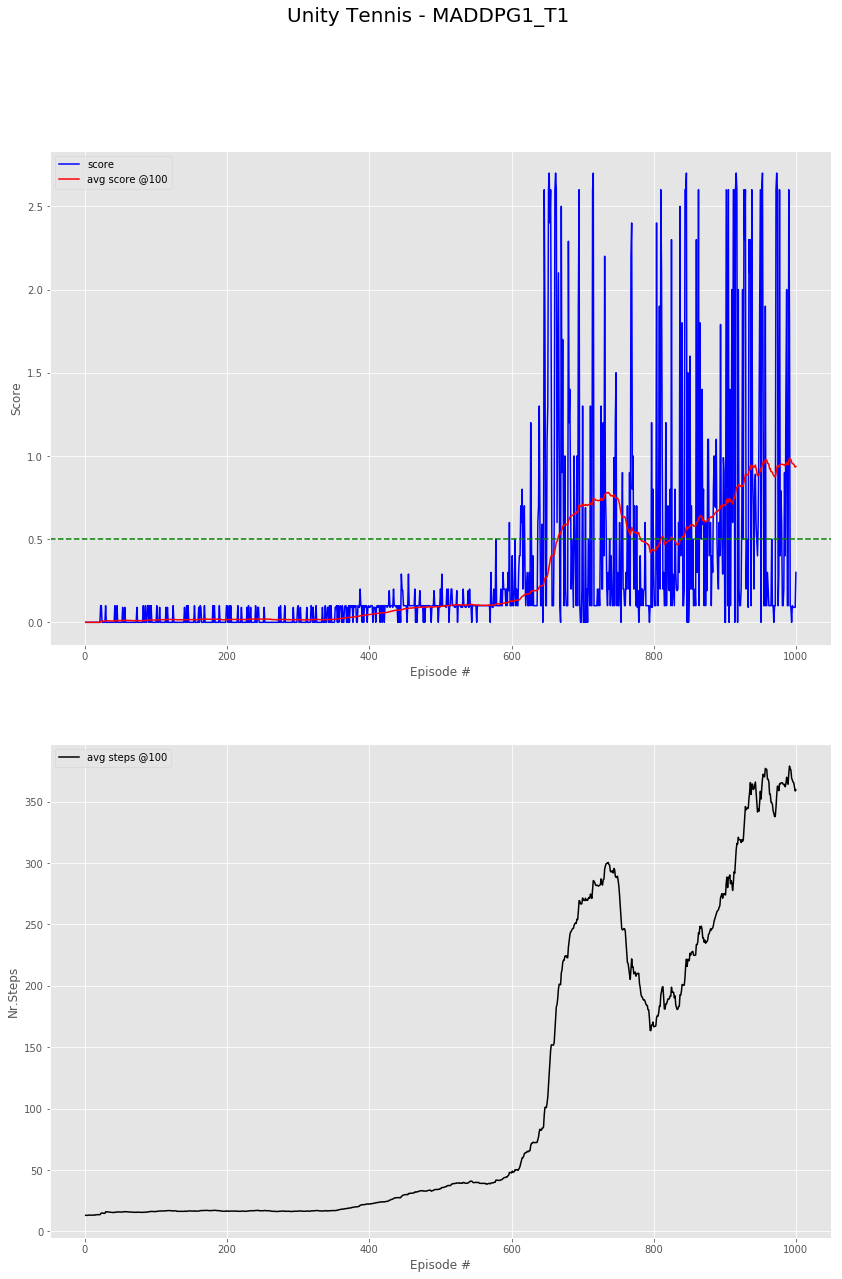

Resetting all seeds...


TRIAL 1 ITERATION 2/2  {'actor_layers': [128, 128], 'critic_state_layers': [128], 'critic_final_layers': [128], 'actor_input_bn': False, 'actor_hidden_bn': True, 'critic_state_bn': True, 'critic_final_bn': False, 'apply_post_bn': False, 'noise_scaling_factor': 2, 'activation': 'relu', 'OUNoise': False, 'noise_scaling_min': 0.5, 'LR_ACTOR': 0.0001, 'LR_CRITIC': 0.0002}
Init GRB v.0.9.1
Agent 'MADDPG2_T1_Agent_1' initialized with:
Actor:
MADDPGActor(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (final_linear): Linear(in_features=128, out_features=2, bias=True)
  (final_activation): Tanh()
)
Critic:
MADDPGCritic(
  (final_layers): ModuleList(
    (0)

KeyboardInterrupt: 

In [10]:
  from workspace_utils import active_session
  n_max_ts = 20000   
    
  dct_grid = {
      "actor_layers" : [ 
              [128, 128],
            ],
      "critic_state_layers" : [
            [128],
          ],
      "critic_final_layers" : [
            [128],
          ],
      "actor_input_bn" : [False],   #, True],
      "actor_hidden_bn" : [True],   #, False]
      "critic_state_bn" : [True],   #, False],
      "critic_final_bn" : [False],  #, True],
      "apply_post_bn"   : [False],  #, True],
      "noise_scaling_factor" : [2], #, 1],
      "activation" : ['relu'],      #, 'selu','elu',],
      "OUNoise" : [False],          #, True],


      "noise_scaling_min"         : [0.2, 0.5],
      "LR_ACTOR"                  : [1e-4],
      "LR_CRITIC"                 : [2e-4],
      }
  
  _combs, _params = grid_dict_to_values(dct_grid)
  results = OrderedDict( 
      {'SOLVED' : [], 'AVG_SCRS':[], 'AVG_STPS':[], 'MODEL' : []}
      )
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 1000)
  plt.style.use('ggplot')
  with active_session(): 
      for trial in range(2):
        for i, _c in enumerate(_combs):
          iteration_name = "MADDPG{}_T{}".format(i+1, trial+1)
          dct_pos = grid_pos_to_params(_c, _params)
          if (
              (dct_pos['apply_post_bn'] == True) and
              (dct_pos['actor_input_bn'] == False) and
              (dct_pos['actor_hidden_bn'] == False) and
              (dct_pos['critic_state_bn'] == False) and
              (dct_pos['critic_final_bn'] == False)
             ):
            continue
          reset_seed()
          print("\n\nTRIAL {} ITERATION {}/{}  {}".format(trial+1, i+1, len(_combs), dct_pos))
          if dct_pos['noise_scaling_factor'] == 1:
            noise_scaling_factor_dec = 1
          else:
            noise_scaling_factor_dec = 0.9999


          eng = MADDPGEngine(action_size=action_size, 
                             state_size=state_size, 
                             n_agents=num_agents,
                             noise_scaling_factor_dec=noise_scaling_factor_dec,
                             name=iteration_name,
                             **dct_pos,
                             )

          res = eng.run_on_unity(env, brain_name,
                                 time_steps_per_episode=n_max_ts,
                                 DEBUG=0)
          solved, all_scores, avg_scores, avg_steps = res
          results['SOLVED'].append(solved)
          results['AVG_SCRS'].append(np.mean(avg_scores))
          results['AVG_STPS'].append(np.mean(avg_steps))
          results['MODEL'].append(iteration_name)
      #    for k,v in dct_pos.items():
      #      if k not in results.keys():
      #        results[k] = []
      #      results[k].append(v)
          df = pd.DataFrame(results).sort_values('AVG_SCRS')
          print(df)
          print("Plotting")
          fig, ax = plt.subplots(2, 1, figsize=(14,20))
          ax[0].plot(np.arange(1, len(all_scores)+1), all_scores,"-b", label='score')
          ax[0].plot(np.arange(1, len(all_scores)+1), avg_scores,"-r", label='avg score @100')
          ax[0].set_ylabel('Score')
          ax[0].set_xlabel('Episode #')
          ax[0].axhline(y=0.5, linestyle='--', color='green')
          ax[0].legend()
          ax[1].plot(np.arange(1, len(all_scores)+1), avg_steps,"-k", label='avg steps @100')
          ax[1].set_ylabel('Nr.Steps')
          ax[1].set_xlabel('Episode #')
          ax[1].legend()
          fig.suptitle("Unity Tennis - " + iteration_name, fontsize=20)
          plt.savefig("img/"+iteration_name+'.png')
          plt.show()


